<img src='images/gdd-logo.png' width='250px' align='right' style="padding: 15px">

# Feature Selection

How do you decide which features to keep and which to drop? And what impact does this decision have on the model?

In this notebook, you will explore ***feature selection***, a crucial process for identifying and selecting the most relevant and informative features from a dataset. Through this exploration, you will gain insights into optimizing your data for improved model performance.

**Program**

- [Data and baseline model](#data)
- [Why do feature selection?](#why)
- [Baseline model](#base)
- [Manual feature selection](#manual)
    - [Missing value ratio](#missing)
    - [Low variance](#lowvar)
    - [High correlation](#corr)
- [Automatic feature selection](#auto)
    - [Low variance](#auto-var)
    - [Statistical testing](#stats)
    - [Selection through embedded models](#model)


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

<a id=data></a>

## Data

The data used in this notebook is the stroke dataset, which has already gone through some feature engineering. The features include:

1. `bmi`: replacing `height` and `weight` using the formula - $ BMI = \dfrac{weight (kg)}{height (m)^2} $
1. `age`: age of the patient
1. `avg_glucose_level`: average glucose level in blood
1. `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
1. `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
1. `ever_married`: 0 if the patient never married, 1 if the patient has been married
1. `mortality_rate`: mortality rate of state of address as given by the [National Center for Health Statistics](https://www.cdc.gov/nchs/pressroom/sosmap/stroke_mortality/stroke.htm)
1. `work_type_*`: 5 dummy (0/1) features for "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
1. `smoking_status_*`:4 dummy (0/1) features for "formerly smoked", "never smoked", "smokes" or "Unknown"
1. `who_*`: 3 dummy features for "Child", "Man" and "Woman"
1. `gender_Male`: 0 if the patient is "Female", 1 if the patient is "Male"
1. `residence_type_Urban`: 0 if the residence is "Rural" and 1 if the residence is "Urban"
1. `state_*`: dummy features (0 or 1) that represent each state of the patient's address
1. `age_*`: 6 features representing age binned into 6 quantiles
1. `bmi_*`: 6 features representing bmi binned into 6 quantiles
1. `avg_glucose_level_*`: 6 features representing avg_glucose_level binned into 6 quantiles

The target feature is:
- `stroke`: 1 if the patient had a stroke or 0 if not

This notebook will assess the existing and added features to ensure they do add value and potentially improve the model performance or interpretability.

In [11]:
stroke = pd.read_csv("data/stroke-engineered.csv")
stroke.head()

,id,gender_Male,age,height,weight,bmi,hypertension,heart_disease,ever_married,avg_glucose_level,...,bmi_3.0,bmi_4.0,bmi_5.0,avg_glucose_level_0.0,avg_glucose_level_1.0,avg_glucose_level_2.0,avg_glucose_level_3.0,avg_glucose_level_4.0,avg_glucose_level_5.0,stroke
0,9046,1,67.00,1.79,117.27,36.60,0,1,1,228.69,...,0,0,0,0,0,0,0,0,1,1
1,51676,0,43.35,1.56,77.49,28.94,0,0,1,202.21,...,0,0,1,0,0,0,0,0,1,1
2,31112,1,80.00,1.75,99.53,32.50,0,1,1,105.92,...,0,0,0,0,0,0,0,1,0,1
3,60182,0,49.00,1.64,92.52,34.40,0,0,1,171.23,...,0,0,0,0,0,0,0,0,1,1
4,1665,0,79.00,1.69,68.55,24.00,1,0,1,174.12,...,1,0,0,0,0,0,0,0,1,1


In [12]:
print(f'Number of feature columns: {stroke.shape[1]-1}')

Number of feature columns: 59


That's quite a lot of features! 

At first glance, it may seem that the more information you feed to the machine learning model, the better. However, simpler models - that is, models trained using fewer features - are usually more effective in a variety of ways. This is why feature selection is so important. 

<a id=why></a>
### <mark>**Exercise:**</mark> Why do feature selection?
1. Can you think of potential benefits of feature selection?
2. What methods of feature selection can you think of? What makes a good or bad feature?

<details>
    
  <summary><span style="color:blue">Show answers</span></summary>
  
1. One of the principles of good machine learning is the so called ***Principle of Parsimony***. It states that given two (nearly) identically-performing models: A complex model and a simple model, the simple model should always be preferred. But why? Because simpler models:
    1. tend to be better generalizers (as they overfit less on uninformative features and noise), meaning they are better in predicting new unseen observations,
    2. require less computational resources, and are therefore faster to train and to perform inference (predictions),
    3. tend to be easier to interpret.
<br>
3. Feature selection methods include: 
    1. checking the correlation between the feature and the target,
    2. removing features with too many missing values,
    3. removing features that are constant or have low-variance,
    4. removing duplicate or very highly correlated features,  
    5. using feature importance metrics of a fitted model to remove low-importance features,
    6. binning multiple sparse or low-importance features into a single more informative feature.
    7. using a "cost" function in the model training that penalizes using too many features,
    8. ... (and many more)
</details>

<a id=base></a>

## Baseline model

Let's start creating the train and tests sets, and a base model pipeline.

In [13]:
drop_cols = 'id'
target_col = 'stroke'

def create_Xy(df, target_col):
    return (
        df.drop(columns=[drop_cols,target_col]),
        df[target_col]
    )

X, y = stroke.pipe(create_Xy, 
                   target_col=target_col,
                   )

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = y,
                                                    )

Some models are more sensitive to a large number of features. One of these models is the K-Nearest Neighbors (KNN) model, which predicts new observation by looking at the majority class of its closest neighbors.

For this reason, two models will be tested: A KNN model as well as a Random Forest.

In [14]:
preprocessor = Pipeline(steps=[
    ('scale', StandardScaler())
])

knn_model = KNeighborsClassifier(n_neighbors=3)

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', knn_model)
])

forest_model = RandomForestClassifier(class_weight='balanced',
                                      max_depth=3,
                                      random_state=42)

forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', forest_model)
])


display(forest_pipeline.fit(X_train, y_train))
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Pipeline(steps=[('scale', StandardScaler())])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        random_state=42))])

Pipeline(steps=[('preprocessor', Pipeline(steps=[('scale', StandardScaler())])),
                ('model', KNeighborsClassifier(n_neighbors=3))])

Now to evaluate both models using the metric AUC due to the imbalanced target feature:

In [15]:
y_baseline_train_probs = knn_pipeline.predict_proba(X_train)[:,1]
y_baseline_test_probs = knn_pipeline.predict_proba(X_test)[:,1]

print(f'KNN train AUC: {round(roc_auc_score(y_train, y_baseline_train_probs),4)}',
      f'KNN test AUC: {round(roc_auc_score(y_test, y_baseline_test_probs),4)}',
      sep='\n'
      )

y_baseline_train_probs = forest_pipeline.predict_proba(X_train)[:,1]
y_baseline_test_probs = forest_pipeline.predict_proba(X_test)[:,1]

print(f'Forest train AUC: {round(roc_auc_score(y_train, y_baseline_train_probs),4)}',
      f'Forest test AUC: {round(roc_auc_score(y_test, y_baseline_test_probs),4)}',
      sep='\n'
      )

KNN train AUC: 0.9838
KNN test AUC: 0.6814
Forest train AUC: 0.9037
Forest test AUC: 0.8808


From the training metrics, it would seem that the KNN performs better than the Random Forest. However, the large drop-off between train and test reveals a highly overfit model. When features are removed it will be good to review both scores to check the KNN will perform as good or better than the Random Forest.

<img src='images/puzzle.png' width='350px' align='right' padding='15px'>

<a id=manual></a>
## Manual feature selection 

To start with, there are feature selection methods that can be done while only looking at the data, which can potentially remove a lot of uninformative features. You will check for features with:

1. [A significant amount of missing data](#missing)
2. [Features with low variance (little variation)](#lowvar)
3. [High correlation with other features](#)

<a id=missing></a>
### Missing value ratio
One of the most common cases of low-quality data are features with many (or even majority) of missing values. 

This isn't an issue in for this dataset as it has already been treated with imputation:

In [16]:
X_train.isnull().sum().sum()

0

<a id=lowvar></a>
### Low-variance features

It is also possible that there are low-variance features.

<mark>**Questions:** </mark>
1. Why would you want to remove features with no or little variance?
2. What could be the risk of removing features with very low (but not zero) variance?<br>***Hint:** Think of datasets with very unbalanced outcome distributions.*

<details>
    
  <summary><span style="color:blue">Show answer</span></summary>

1. Because (systematic) variance is information! It is impossible to predict differing outcomes, if your feature column does not possess any variation.<br><br>
2. In practice, low-variance features are often dummy features with very few occurances (i.e., lots of `0`'s and very few `1`'s). However, sometimes these rare `1`'s can be very predictive! This especially occurs, if the outcome distribution is also very unbalanced (i.e., very few `1`'s that we need to predict). As an example, imagine you would want to predict a rare event like a `Tsunami` and a feature of your's is `earth_quake_last_24h`. The earth quake feature may be filled with many zeros (earth quakes are rare), but if there is a `1`, it will almost perfectly coincide with `Tsunami=1`, (because, unless an astroid hits the earth again, earth quakes are the only cause for large Tsunamis). 

</details>

**Inspecting low-variance** 

The first thing is to investigate your data and to check if you can see any low variance.

- In the case of **dummy features**, you can check for the value distribution or mean. A mean that has the value of `1` or all `0`, suggest that all (or almost all) of the values are equal to `0` or `1` accordingly. 
- In the case of **continuous features**, you can directly check the range of values (to check for and potentially account for outliers) and the variance.

To check the range of **continuous** low-variance features you can inspect the variation visually.

In [17]:
(
    X_train
    .loc[:, lambda col: ~col.isin([0,1]).all()]
    .columns
)

Index(['age', 'height', 'weight', 'bmi', 'avg_glucose_level',
       'mortality_rate'],
      dtype='object')

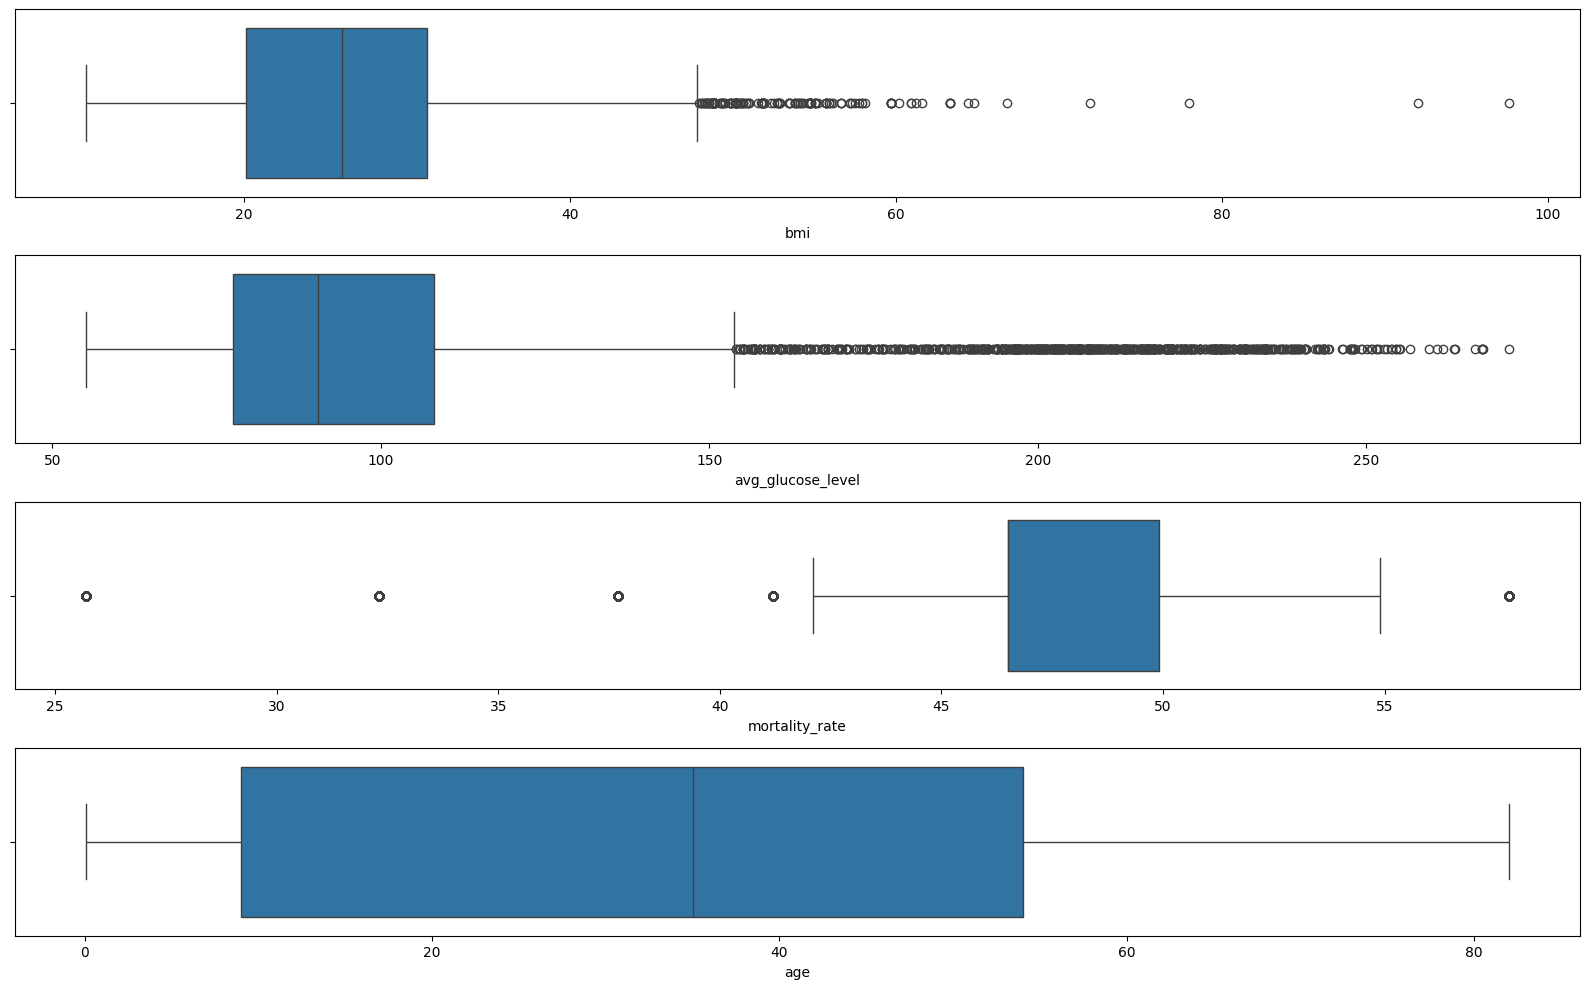

In [18]:
fig, axs = plt.subplots(4, figsize = (16,10))

sns.boxplot(data = stroke, x = "bmi", ax = axs[0])
sns.boxplot(data = stroke, x = "avg_glucose_level", ax = axs[1])
sns.boxplot(data = stroke, x = "mortality_rate", ax = axs[2])
sns.boxplot(data = stroke, x = "age", ax = axs[3])

fig.tight_layout()

Each box represents the interquartile range (the middle 50% of the data). The wider the box, the more varied the data is. Since each continuous feature is represented by a very clear box, suggesting that there is enough variance in each of these features.

In this case there are very few continuous features, making it possible to visually inspect each one. There are also ways to do this automatically which will be covered later. However, it should be done with caution as the removal of features should be done with a good understanding of what is being removed and why.

What about those **dummy features** that indicate using values 0 or 1? The below code selects only those features and calculates the mean.

In [19]:
(
    X_train
    .loc[:, lambda col: col.isin([0,1]).all()]
    .mean().round(3)
    .sort_values()
)

work_type_Never_worked            0.003
state_KY                          0.006
state_VA                          0.007
state_OH                          0.008
state_WV                          0.013
state_NJ                          0.016
state_TN                          0.016
state_CA                          0.019
state_SC                          0.024
heart_disease                     0.032
state_AR                          0.036
state_GA                          0.036
state_PA                          0.040
state_NY                          0.051
state_NC                          0.054
hypertension                      0.059
state_MS                          0.063
state_LA                          0.078
state_AL                          0.092
work_type_Govt_job                0.094
age_2.0                           0.103
smoking_status_smokes             0.114
avg_glucose_level_5.0             0.116
work_type_Self-employed           0.119
age_5.0                           0.120


If the mean is equal (or extremely close) to 0 or 1, it means that either all or almost all the values are 0 or 1 suggesting that there is little variance in these features.

<mark>**Question**:</mark>
1. What can you gather about the amount of people who never worked?
2. What is the split of male/female? Is it 50/50?
3. Should features be removed when they show a low amount of variance, but still have some differing value?


<details>
    
  <summary><span style="color:blue">Show answers</span></summary>
  
1. There are very few people who never worked - 0.3% - in this data. 
2. ~44% of the patients are male and ~56% are female
3. The features with mean values close to zero, eg. `work_type_Never_worked` could be good candidates for removing since they have little variation, however it is also important to consider how predictive they are. Low variance does not always equal low feature importance. On the other hand, zero variance features can always be removed.
</details>

#### Grouping features together

Another thing to note in this analysis is the lack of data in some of the states, whereas Florida (`FL`) and Alabama (`AL`) are overrepresented. This could be due to the location of the study, or the aim of the study only focussing on specific states. 

In this case the the features could be combined so that the states are grouped together.

One method could be to look at the mean stroke (the stroke rate) and the number of patients per state, and group those with smaller number of patients but with similar stroke rates. This is tricky as this should *only be investigated on the train data* to avoid learning anything about relationships between features and the target from the test data.

To simplify this process, only the above distributions by state will be taken into the account - below the states are divided into Florida (`FL`), Alabama (`AL`) and other (all remaining states).

In [20]:
other_states = [col for col in X_train.columns if col.startswith('state') and col not in ('state_FL', 'state_AL')]
print(other_states)

['state_AR', 'state_CA', 'state_GA', 'state_KY', 'state_LA', 'state_MS', 'state_NC', 'state_NJ', 'state_NY', 'state_OH', 'state_PA', 'state_SC', 'state_TN', 'state_VA', 'state_WV']


In [21]:
X_train_var = (
    X_train
    .assign(other_states = lambda df: df[other_states].sum(axis=1))
    .drop(columns=other_states)
)

X_test_var = (
    X_test
    .assign(other_states = lambda df: df[other_states].sum(axis=1))
    .drop(columns=other_states)
)

# check ow many features were dropped
features_dropped_var = X_train.shape[1] - X_train_var.shape[1]
print("Number of low variance state columns removed:", features_dropped_var)

Number of low variance state columns removed: 14


<a id=corr></a>
### High-correlation features

Some features may be "too related" to each other and essentially be copies of the same information. 

<mark>**Questions**:</mark>
1. Why is having copies of the same information something that you want to avoid?
2. How can you find highly correlated features?
3. Can you think of a limitation of using correlation to see if two features are related to each other? 


<details>
    
  <summary><span style="color:blue">Show answer</span></summary>
  
1. High-correlation features can have multiple disadvantages. For example, they can:
    1. add unnecessary model complexity by adding redundant information. For example, the columns `who_woman` and `gender_woman` contain exactly the same information.
    2. increase overfitting and reduce the generalizability of the model by overfitting on additional noise,
    3. increase the computational costs without adding performance,
    3. break some machine learning models. For example, linear regression models cannot (mathematically) be fitted with perfectly correlated features.
    4. severely bias model explainability techniques, giving low importance to features that might actually be very predictive.
<br>
2. By calculating the correlations between each all feature combinations.
<br><br>
3. Correlations model a linear relationship between two variables. If two features are non-linearly related, they can possess a low correlation although they are very related to each other.
</details>


You can inspect feature "relatedness" using a **correlation map** which works very well given you have a relatively small feature set.

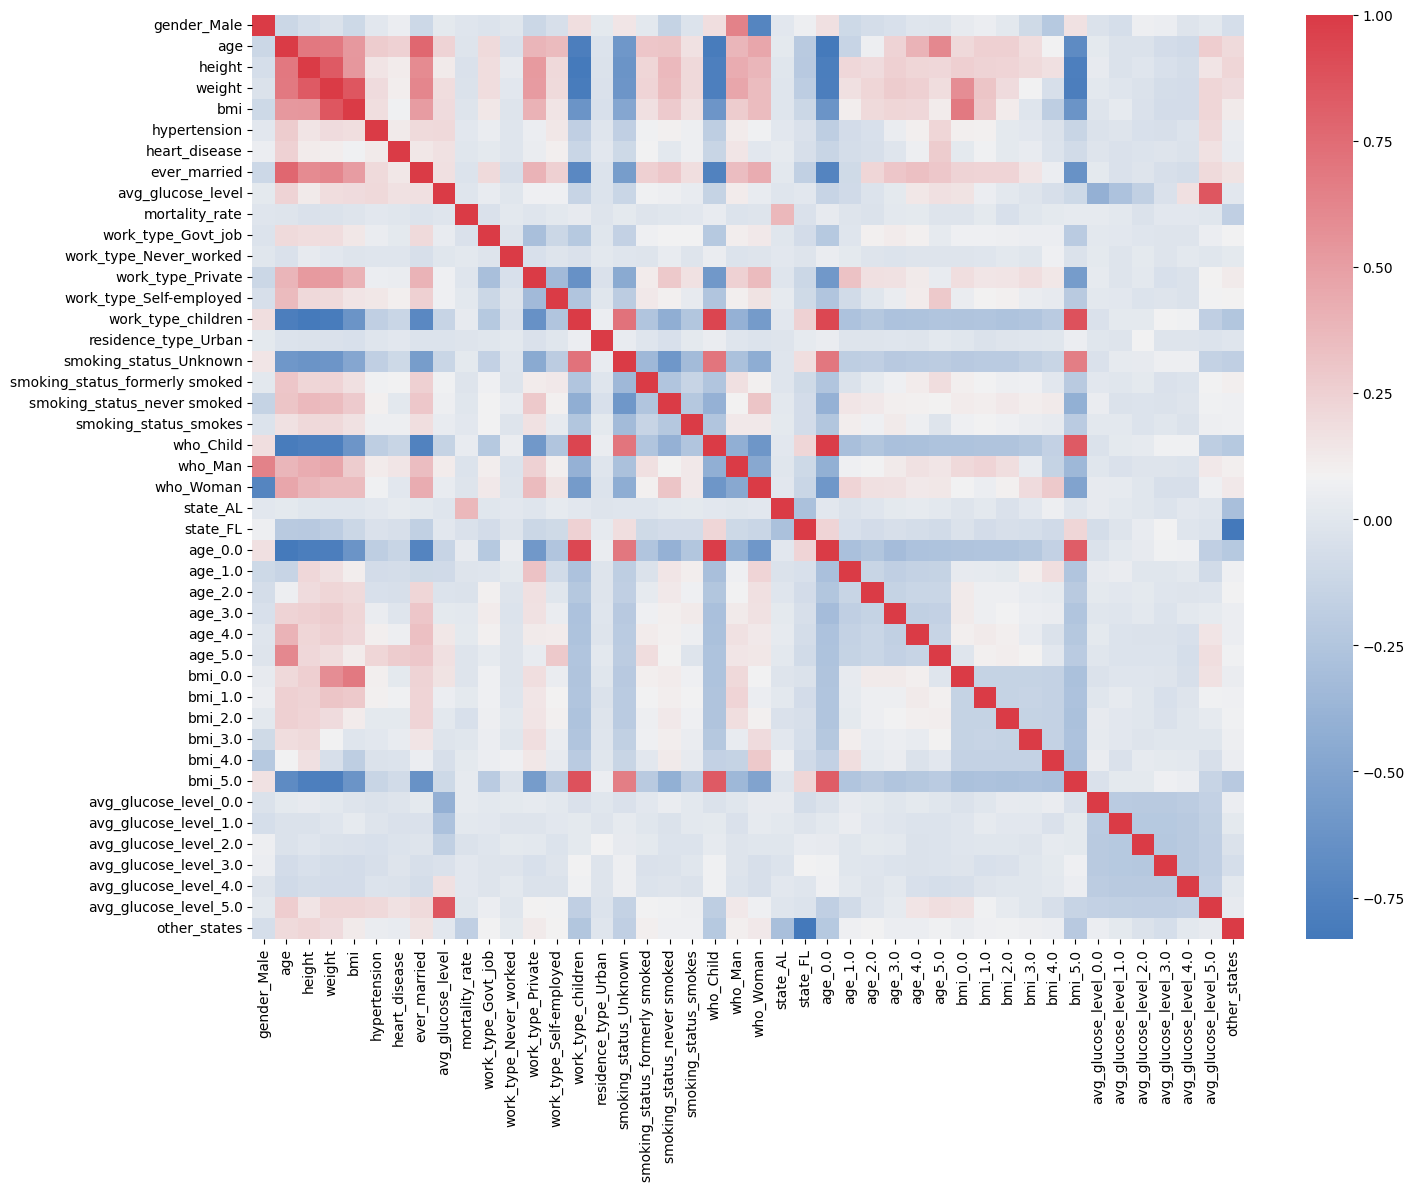

In [22]:
fig, ax = plt.subplots(figsize = (16,12))
sns.heatmap(X_train_var.corr(), cmap = sns.diverging_palette(250, 10, as_cmap=True), ax = ax);

<mark>**Questions**:</mark>
1. Which features are highly correlated (positively)?
2. How about features with a high negative correlation?

1.
2.

In this particular correlation map, there are a few features that seem to be highly correlated: e.g. `who_Child` and `age_0.0`, or `gender_Male` and `who_Man`. 

Let's inspect them a little bit further. 

In [23]:
display(X_train[['who_Man','gender_Male']].corr())
pd.crosstab(X_train['who_Man'], X_train['gender_Male'])

,who_Man,gender_Male
who_Man,1.000000,0.636501
gender_Male,0.636501,1.000000


gender_Male,0,1
who_Man,,
0,3702,1331
1,0,1632


How about the relationship between `who_Child` and `age_0.0` (the lowest of the six age bins you created earlier)?

In [24]:
display(X_train[['who_Child','age_0.0']].corr())
pd.crosstab(X_train['who_Child'], X_train['age_0.0'])

,who_Child,age_0.0
who_Child,1.00000,0.98426
age_0.0,0.98426,1.00000


age_0.0,0,1
who_Child,,
0,4320,0
1,48,2297


> **What threshold should I use?**<br>There is no single answer to this question. At which point two features are *too* highly correlated depends on the use case and what works for your case. As a rule of thumb, correlation values of above $\pm 0.9$ should be removed. 

In this case, that would mean that either `who_Child` or `age_0.0` could be removed. 

Let's first look at some other features that are highly correlated, but harder to spot on the heatmap.

#### Binned feature duplicates?

Another thing to look at here are the features that have been binned, but their original features have remained. Zooming in on these features in the heatmap shows this in more detail:

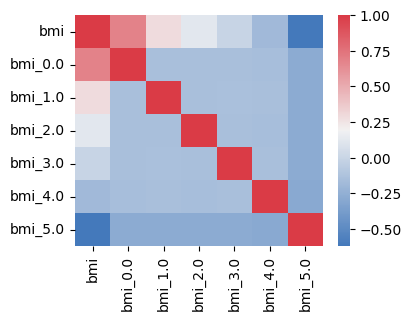

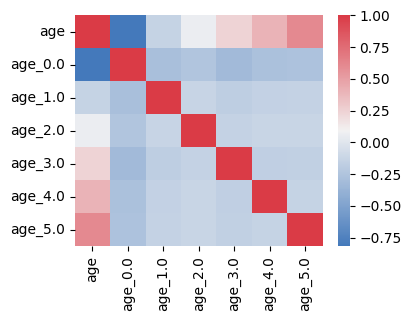

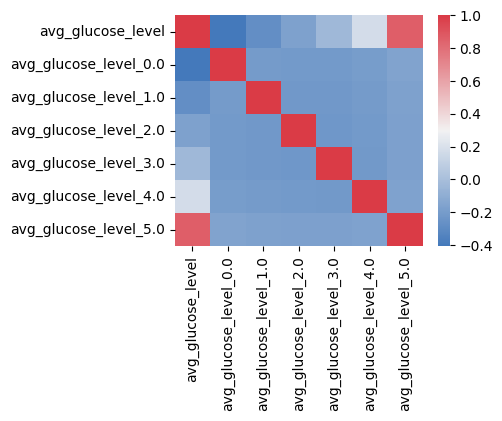

In [25]:
original_features = ['bmi', 'age', 'avg_glucose_level']
for org_f in original_features:
    all_binned_features = [col for col in X_train.columns if col.startswith(org_f)]
    fig, ax = plt.subplots(figsize = (4,3))
    sns.heatmap(X_train_var[all_binned_features].corr(), cmap = sns.diverging_palette(250, 10, as_cmap=True), ax = ax);

If you look only in the first row, it is clear to see the relationship between `age`, `bmi` or `avg_glucose_level` and the features that represent their binning. 

It does not make sense to keep both features (the binned + original) as this will overrepresent this feature in the model.

Since the goal of feature selection is to improve model interpretability and the generalization of the model, the binning features will be kept. However this decision should be taken in combination with domain expertise.

In [26]:
high_corr_columns_to_drop = ['age', 'bmi', 'avg_glucose_level', 'who_Child']

X_train_corr = X_train_var.drop(columns=high_corr_columns_to_drop)
X_test_corr = X_test_var.drop(columns=high_corr_columns_to_drop)

# check how many features were dropped
features_dropped_corr = len(high_corr_columns_to_drop)
print("Number of features dropped due to high correlation:", features_dropped_corr)

Number of features dropped due to high correlation: 4


Now, let's review the model performance with this new data, since all the transformations are done in pandas the only requirement is to fit pipeline to the new data:

In [27]:
knn_pipeline.fit(X_train_corr, y_train)
forest_pipeline.fit(X_train_corr, y_train)

Pipeline(steps=[('preprocessor', Pipeline(steps=[('scale', StandardScaler())])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        random_state=42))])

In [28]:
y_baseline_train_probs = knn_pipeline.predict_proba(X_train_corr)[:,1]
y_baseline_test_probs = knn_pipeline.predict_proba(X_test_corr)[:,1]

print(f'KNN train AUC: {round(roc_auc_score(y_train, y_baseline_train_probs),4)}',
      f'KNN test AUC: {round(roc_auc_score(y_test, y_baseline_test_probs),4)}',
      sep='\n'
      )

y_baseline_train_probs = forest_pipeline.predict_proba(X_train_corr)[:,1]
y_baseline_test_probs = forest_pipeline.predict_proba(X_test_corr)[:,1]

print(f'Forest train AUC: {round(roc_auc_score(y_train, y_baseline_train_probs),4)}',
      f'Forest test AUC: {round(roc_auc_score(y_test, y_baseline_test_probs),4)}',
      sep='\n'
      )

KNN train AUC: 0.9799
KNN test AUC: 0.6582
Forest train AUC: 0.9029
Forest test AUC: 0.8756


There is a slight uplift in the performance of the test data in the KNN model, and a drop in the train suggesting better (but still bad) generalization. The model is still too overfit to be suitable for its purpose - let's carry out some further feature selections.

### Manual feature selection conclusion:

In [29]:
print('0 features with too many missing values were dropped.')
print(f'{features_dropped_var} low-variance features were dropped.')
print(f'{features_dropped_corr} high-correlation features were dropped.')

0 features with too many missing values were dropped.
14 low-variance features were dropped.
4 high-correlation features were dropped.


---

<a id=auto></a>

## Automatic Feature Selection

Instead of (de)selecting features by hand, you can also automate the process. There are a number of automatic feature selection techniques included in Sklearn.

<a id=auto-var></a>
### `VarianceThreshold` Transformer

A quick way of removing features with little variation, is by making use of the [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) transformer. This transformer allows you to specify a parameter called `threshold`. Features with variance below this threshold will be discarded.

This should be done with caution, and the features should always be reviewed afterwards to be fully aware of what is happening. The benefit of this method that you're able to add the preprocessor pipeline! 

<mark>**Question:** Can you guess which feature(s) it will drop?</mark> (Think about what you saw previously)

In [30]:
from sklearn.feature_selection import VarianceThreshold

preprocessor = Pipeline(steps=[
    ('vt', VarianceThreshold(0.05))
]).set_output(transform="pandas")

X_train_var = preprocessor.fit_transform(X_train_corr)
X_test_var = preprocessor.transform(X_test_corr)

num_before = X_train_corr.shape[1]
num_after = X_train_var.shape[1]
print(f'Number of features eliminated: {num_before - num_after}')

Number of features eliminated: 2


You can see which features were removed by using the `get_support` method.

In [31]:
cols_above_treshold = preprocessor['vt'].get_support()
features_droppped_vartrans = sum(~cols_above_treshold)

X_train_corr.columns[~cols_above_treshold]

Index(['heart_disease', 'work_type_Never_worked'], dtype='object')

These was the features identified earlier by looking at the means!

#### <mark>Questions</mark>
1. What does the value `0.05` indicate in the `threshold`?
2. How could you remove only features that only contain one value (eg. a feature of only 1s)?

<details>
    
  <summary><span style="color:blue">Show answer</span></summary>
  
1. Features with a (training set) variance lower than this threshold will be removed.
2. By setting `threshold = 0`.

</details>

It would be good to carry out some more analysis on these features, since rare features can still be informative (especially when also having rare outcomes). 

A good rough estimate of whether a feature could be informative is looking at the correlation between the feature and the outcome:

In [32]:
stroke[['work_type_Never_worked','stroke']].corr()

,work_type_Never_worked,stroke
work_type_Never_worked,1.000000,-0.009818
stroke,-0.009818,1.000000


In [33]:
stroke[['heart_disease','stroke']].corr()

,heart_disease,stroke
heart_disease,1.00000,0.15476
stroke,0.15476,1.00000


While `work_type_Never_worked` seems to be completely unrelated to stroke, `heart_disease` and stroke are somewhat related. 

Since `work_type_Never_worked` was the lowest variance feature, you can adjust the threshold to just above its value to still keep `heart_disease`. This will be implemented in the pipeline below.

### Review after VarianceThreshold:

In [34]:
print(f'{0} features with too many missing values were dropped.')
print(f'{features_dropped_var} low-variance features were dropped.')
print(f'{features_dropped_corr} high-correlation features were dropped.')
print(f'{features_droppped_vartrans-1} feature was dropped with the VarianceThreshold transformer.')

0 features with too many missing values were dropped.
14 low-variance features were dropped.
4 high-correlation features were dropped.
1 feature was dropped with the VarianceThreshold transformer.


<a id=stats></a>
## Statistical testing

### Building a baseline model
The feature selection above only focused on features' *overall informativeness*, but not how informative they could be to *predict the target variable*. Some variables may be completely unrelated to the target or even mainly consist of noise. 

In this section, you will investigate more ways to **eliminate features using statistical testing**.

First review the current baseline model performance with the features that remained after the preliminary manual feature selection.

In [35]:
# keep heart_disease
threshold = X_train['work_type_Never_worked'].mean() + 1e-4

preprocessor = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('vt', VarianceThreshold(threshold))
])

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', knn_model)
])

forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', forest_model)
])

knn_pipeline.fit(X_train_corr, y_train)
forest_pipeline.fit(X_train_corr, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scale', StandardScaler()),
                                 ('vt',
                                  VarianceThreshold(threshold=0.002950712678169542))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        random_state=42))])

The k-Nearest Neighbors algorithm calculates the distance between samples based on each feature equally, and is therefore notoriously sensitive to irrelevant features or features with a low predictive value. Let's see how it does:

In [36]:
y_baseline_train_probs = knn_pipeline.predict_proba(X_train_corr)[:,1]
y_baseline_test_probs = knn_pipeline.predict_proba(X_test_corr)[:,1]

print(f'KNN train AUC: {round(roc_auc_score(y_train, y_baseline_train_probs),4)}',
      f'KNN test AUC: {round(roc_auc_score(y_test, y_baseline_test_probs),4)}',
      sep='\n'
      )

y_baseline_train_probs = forest_pipeline.predict_proba(X_train_corr)[:,1]
y_baseline_test_probs = forest_pipeline.predict_proba(X_test_corr)[:,1]

print(f'Forest train AUC: {round(roc_auc_score(y_train, y_baseline_train_probs),4)}',
      f'Forest test AUC: {round(roc_auc_score(y_test, y_baseline_test_probs),4)}',
      sep='\n'
      )

KNN train AUC: 0.9799
KNN test AUC: 0.6582
Forest train AUC: 0.9029
Forest test AUC: 0.8756


<a id=stats></a>
### Correlation between features and target

Your first approach to further eliminate irrelevant, or the least contributing features, will be through statistical testing. 

With Scikit-Learn, `f_classif` can be used for classification problems and `f_regression` for regression problems. They return an `f_statistic` array and a `p_values` array. The f-statistic provides an estimate of the linear dependency between a feature and the target variable. Meanwhile, the p-value indicates the likelihood of obtaining the observed f-statistic score, or a higher one, if the variable had no relationship with the target. You can use the p-value to determine which features to eliminate. 

In [37]:
from sklearn.feature_selection import f_classif

# Perform test. 
_, p_values = f_classif(X_train_corr, y_train)

# Columns to drop. 
columns_to_drop = X_train_corr.columns[p_values > 0.05]

print(f'Number of features to drop: {len(columns_to_drop)}\n')
print(f'Column names: {columns_to_drop.values}')

Number of features to drop: 13

Column names: ['gender_Male' 'work_type_Never_worked' 'residence_type_Urban'
 'smoking_status_never smoked' 'state_AL' 'age_3.0' 'bmi_0.0' 'bmi_3.0'
 'bmi_4.0' 'avg_glucose_level_0.0' 'avg_glucose_level_1.0'
 'avg_glucose_level_3.0' 'avg_glucose_level_4.0']


When using these Scikit-Learn f-test functions, you have to manually create the new version of your dataset. Therefore, a better approach is to use `SelectKBest` **in your pipeline**.

This transformer allows you to determine exactly the number of features you want and decides which features to use based on some metric. `SelectKBest` selects features according to the k highest scores. This selector takes two arguments; the function to score the feature importance (typically `f_classif` for classification, `f_regression` for regression) and the number of features to select k (default 10). 

### <mark>**Exercise:**</mark> Try out SelectKBest
1. Add `SelectKBest` to the 2 pipelines below and select only the 10 best features. You can find the documentation on `SelectKBest` [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest).
2. Check what it did to the performance of the model.
3. Trial different values for `SelectKBest`, what happens to the model performance? What can you conclude?

In [46]:
from sklearn.feature_selection import SelectKBest, f_classif

skb_knn_pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ('preprocessor', preprocessor),
    ('model', knn_model)
])

skb_forest_pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ('preprocessor', preprocessor),
    ('model', forest_model)
])

skb_knn_pipeline.fit(X_train_corr, y_train)
skb_forest_pipeline.fit(X_train_corr, y_train)

y_baseline_train_probs = skb_knn_pipeline.predict_proba(X_train_corr)[:,1]
y_baseline_test_probs = skb_knn_pipeline.predict_proba(X_test_corr)[:,1]

print(f'KNN train AUC: {round(roc_auc_score(y_train, y_baseline_train_probs),4)}',
      f'KNN test AUC: {round(roc_auc_score(y_test, y_baseline_test_probs),4)}',
      sep='\n'
      )

y_baseline_train_probs = skb_forest_pipeline.predict_proba(X_train_corr)[:,1]
y_baseline_test_probs = skb_forest_pipeline.predict_proba(X_test_corr)[:,1]

print(f'Forest train AUC: {round(roc_auc_score(y_train, y_baseline_train_probs),4)}',
      f'Forest test AUC: {round(roc_auc_score(y_test, y_baseline_test_probs),4)}',
      sep='\n'
      )

KNN train AUC: 0.8627
KNN test AUC: 0.6481
Forest train AUC: 0.8732
Forest test AUC: 0.8574


In [39]:
# %load answers/feature_selection/select-k-best.py

<details>
    
  <summary><span style="color:blue">Conclusion</span></summary>
  
Removing features has improved the model's ability to generalize, meaning it is no longer overfitting on the Random Forest. There has been the same kind of improvement on the KNN model but to a lesser extent. In this case, a Random Forest is probably a better fit for this model. This could be due to the relationship of the features to the target not being linear, but  that would need to be investigated further to confirm.

</details>

<a id=model></a>
## Selection through embedded models

Even with the techniques used above, selecting the right features can be a tricky problem. This raises an interesting question: Should a **model** itself not be able to determine which features are important? 

In the KNN algorithm, data points are compared to one another using a distance metric, where each feature contributes equally to the calculated distance. This means that irrelevant features can distort the results. 

However, other families of algorithms are **less sensitive** to redundant or irrelevant features. Examples include Linear Regression, Decision Trees or Random Forest algorithms. You will use the latter to **determine which features are the most important ones.** 

In [40]:
forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', forest_model)
])

forest_pipeline.fit(X_train_corr, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scale', StandardScaler()),
                                 ('vt',
                                  VarianceThreshold(threshold=0.002950712678169542))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        random_state=42))])

In [41]:
y_forest_train_probs = forest_pipeline.predict_proba(X_train_corr)[:,1]
y_forest_test_probs = forest_pipeline.predict_proba(X_test_corr)[:,1]

print(f'Train AUC: {round(roc_auc_score(y_train, y_forest_train_probs),4)}',
      f'Test AUC: {round(roc_auc_score(y_test, y_forest_test_probs),4)}',
      sep='\n'
      )

Train AUC: 0.9029
Test AUC: 0.8756


The overall performance is better than the k-nearest neighbors model, even when the number of features has been reduced through `f_classif`.

For certain models, after training you can extract the **feature importances**. Here, features that are highly associated with the outcome are considered more 'important'. For a Random Forest, they are the average of the feature importances for all the trees in the forest.

Let's take a look at the 25 most important features based on your model's feature importances:

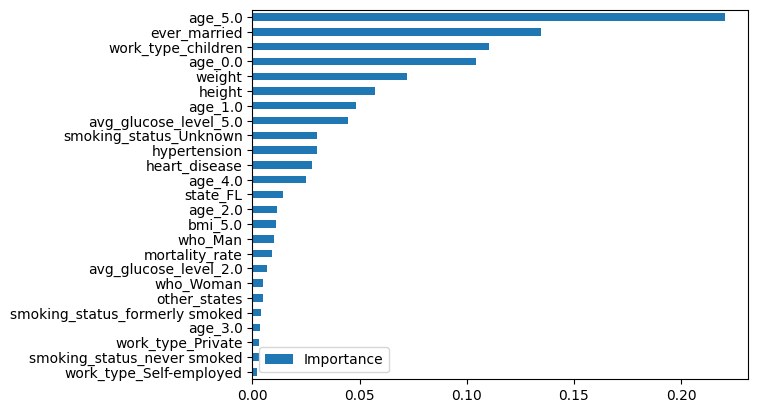

In [42]:
(
    pd.DataFrame(
        forest_pipeline['model'].feature_importances_, 
        index=forest_pipeline['preprocessor'].get_feature_names_out(),
        columns=['Importance'])
    .sort_values(by='Importance')
    .tail(25)
    .plot(kind='barh')
);

With the Random Forest model, the majority of feature importances are almost zero. This is a clear indication that the model is actually mostly using the information contained in **a few most informative features**.

So, does that mean that you could perform feature selection through training a _Random Forest_ model, while using _another algorithm_ type for the eventual model? Exactly!

What scikit-learn allows you to do in such cases is to introduce feature selection as a new preprocessing step of the pipeline. A tool called `SelectFromModel` allows a preliminary use of a model to determine the most contributing features that should be selected. Then only the selected features are passed further down the pipeline.

In [43]:
from sklearn.feature_selection import SelectFromModel

sfm_knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(max_depth=3, 
                                                                 class_weight='balanced')
                                          )),
    ('model', knn_model)])

sfm_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(max_depth=3, 
                                                                 class_weight='balanced')
                                          )),
    ('model', forest_model)])

sfm_knn_pipeline.fit(X_train_corr, y_train)
sfm_forest_pipeline.fit(X_train_corr, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scale', StandardScaler()),
                                 ('vt',
                                  VarianceThreshold(threshold=0.002950712678169542))])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(class_weight='balanced',
                                                                  max_depth=3))),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        random_state=42))])

In [44]:
y_sfm_train_probs = sfm_knn_pipeline.predict_proba(X_train_corr)[:,1]
y_sfm_test_probs = sfm_knn_pipeline.predict_proba(X_test_corr)[:,1]

print(f'Train AUC: {round(roc_auc_score(y_train, y_sfm_train_probs),4)}',
      f'Test AUC: {round(roc_auc_score(y_test, y_sfm_test_probs),4)}',
      sep='\n'
      )

y_sfm_train_probs = sfm_forest_pipeline.predict_proba(X_train_corr)[:,1]
y_sfm_test_probs = sfm_forest_pipeline.predict_proba(X_test_corr)[:,1]

print(f'Train AUC: {round(roc_auc_score(y_train, y_sfm_train_probs),4)}',
      f'Test AUC: {round(roc_auc_score(y_test, y_sfm_test_probs),4)}',
      sep='\n'
      )

Train AUC: 0.9794
Test AUC: 0.6062
Train AUC: 0.8883
Test AUC: 0.8615


This approach hasn't improved the performance, but the model has been simplified by using fewer features, without reducing the performance significantly. 

Also note that the overfitting has greatly improved on the KNN, giving more confidence in both models. 

Reducing complexity (by removing unimportant features) when building your model can also help improve runtime, resulting in less overhead and quicker predictions as well as reducing the data collection requirements in production.

<details>
    
  <summary><span style="color:blue">Bonus information: Penalized models </span></summary>
  
In practice, `SelectFromModel` is most often used in combination with what we call a _penalized_ model. Linear regression, for example, has a penalized version called `Lasso` or `L1` regression. By adding a special term to our regular cost function, the model is discouraged from unnecessary model complexity: 

$$ J_{L1}(\mathbf{w})= \frac{1}{n}\sum_{i=1}^n\left(y_i-y( \mathbf{w},\mathbf{x}^i) \right)^2 + \lambda \sum_{j=1}^m \left|w_j\right| $$

`Lasso` regression would punish your linear model for having too many large coefficients for variables that barely contribute for predictions. It will naturally push those coefficients towards zero, and therefore we can use it more easily as a feature selection technique.

For this reason, the two most popular selection models used with `SelectFromModel` are  `Lasso` for regression problems and for classification `LinearSVC(penalty="l1")` - linear support vector machine classifier with an additional Lasso-like penalty term.

</details>

# <mark>Hackathon</mark>
Perform automatic feature selection with `SelectKBest` and `SelectFromModel` on the hackathon dataset. How does it influence the performance?

In [45]:
# add your code

## Summary

Feature selection is important for many reasons:

- Most real world datasets are very large and hard to comprehend
- Most prediction problems can be solved with only a fraction of features
- Stopping to collect irrelevant features means saved costs
- Many ML models perform much better after feature selection, for some it is almost a must
- Feature selection simplifies the interpretability of ML models

In this notebook you have considered a variety of approaches for feature selection. Some approaches are immediately available for raw data, where features can be manually excluded if you find:

- Too many **missing values**  
- Too little value **variance** (see [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold))
- **High correlation** with other features or low correlation with the target

Other approaches that can be directly included in the pipeline are: 
- **Statistical testing** where little contributing features are removed (see [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)). 
- **Model-based selection** where a(n often penalized) model is used to the determine and eliminate the least contributing features (see [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)).


In practice it is advised to try various feature selection techniques and try to be conservative: by trying to remove 'irrelevant' features carelessly, you may accidentally remove integral parts of the data that could have substantially helped the model.